In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
df = pd.read_csv('DataFrame.csv')
df.head()

,Datum,Merkmal,Merkmalwert,Bestätigte Menge,Relativer Anteil,USTR10Y,CBIPSFE,WeizenSpot,CornSpot,CBI,GER10Y,WtiOilSpot,SoySpot,CBIPS,AgriSpot
0,2014-01-01,B10,B10-0030,0,0.000000,3.006,14.0,197.738,187.924,18.2,1.941,98.04,246.732,22.4,200.399
1,2014-02-01,B10,B10-0030,0,0.000000,2.582,16.5,182.795,190.254,15.5,1.647,96.43,246.293,14.4,201.583
2,2014-03-01,B10,B10-0030,0,0.000000,2.608,9.3,204.039,200.847,10.8,1.563,104.92,269.561,12.4,221.079
3,2014-04-01,B10,B10-0030,48,0.125654,2.755,-1.0,222.170,215.466,4.1,1.581,99.74,281.258,9.2,233.772
4,2014-05-01,B10,B10-0030,42,0.156134,2.613,-12.7,241.438,212.924,-6.4,1.470,99.42,242.195,0.0,236.510


In [3]:
df[df["Bestätigte Menge"] > 0].shape[0]

11404

In [3]:
class TimeSeriesSequencer:
    def __init__(self, file_path, date_column, target_column, sequence_length=12):
        """
        Initialisiert die Klasse TimeSeriesSequencer.

        :param file_path: Pfad zur CSV-Datei mit den Daten
        :param date_column: Spaltenname für das Datum
        :param target_column: Spaltenname für die Zielvariable
        :param sequence_length: Länge der Sequenzen
        """
        self.file_path = file_path
        self.date_column = date_column
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.data = None
        self.label_encoders = {}
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        
    def load_data(self):
        """
        Lädt die Daten aus der CSV-Datei und erstellt zusätzliche Features basierend auf dem Datum.
        """
        # Laden der CSV-Datei
        self.data = pd.read_csv(self.file_path)
        # Konvertieren der Datumsspalte in das Datetime-Format
        self.data[self.date_column] = pd.to_datetime(self.data[self.date_column])
        # Erstellen von Jahr- und Monatsspalten
        self.data['Jahr'] = self.data[self.date_column].dt.year
        self.data['Monat'] = self.data[self.date_column].dt.month
        # Erstellen zyklischer Eigenschaften für den Monat
        self.data['Monat_sin'] = np.sin(2 * np.pi * self.data['Monat'] / 12)
        self.data['Monat_cos'] = np.cos(2 * np.pi * self.data['Monat'] / 12)
        
    def encode_categorical_features(self, categorical_features):
        """
        Kodiert kategoriale Merkmale mittels Label-Encoding.

        :param categorical_features: Liste der kategorialen Merkmale
        """
        for feature in categorical_features:
            # Initialisieren des LabelEncoders
            le = LabelEncoder()
            # Anpassen und Transformieren der Daten
            self.data[f'{feature}_encoded'] = le.fit_transform(self.data[feature])
            # Speichern des LabelEncoders
            self.label_encoders[feature] = le

    def normalize_features(self, continuous_features):
        """
        Normalisiert kontinuierliche Merkmale.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        """
        # Normalisieren der kontinuierlichen Merkmale außer "Jahr"
        other_cont_features = [feat for feat in continuous_features if feat != 'Jahr']
        self.data[other_cont_features] = self.scaler_X.fit_transform(self.data[other_cont_features])
        # Normalisieren der "Jahr"-Spalte separat
        self.data[['Jahr']] = MinMaxScaler().fit_transform(self.data[['Jahr']])
        
    def create_sequences(self, continuous_features, encoded_features):
        """
        Erstellt Sequenzen für das Training des Modells.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        :param encoded_features: Liste der kodierten Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = [], [], [], [], []
        
        # Gruppieren der Daten nach "Merkmalwert"
        for merkmalwert, group in self.data.groupby('Merkmalwert'):
            # Sortieren der Gruppen nach Datum
            group = group.sort_values(by=self.date_column)
            # Auswählen der kontinuierlichen und kodierten Merkmale
            X_continuous = group[continuous_features]
            X_encoded = group[encoded_features]
            
            # Erstellen der Zielsequenzen für die nächsten 12 Monate
            y = pd.concat([group[self.target_column].shift(-i) for i in range(1, 13)], axis=1).dropna()
            y.columns = [f'R_A_{i+1}' for i in range(12)]
            
            # Überprüfen, ob genügend Daten vorhanden sind
            if len(y) < self.sequence_length + 12 - 1:
                continue
            
            # Anpassen der Features an die Zielsequenzen
            X_continuous = X_continuous.iloc[:len(y)]
            X_encoded = X_encoded.iloc[:len(y)]
            
            # Normalisieren der Zielvariablen
            y_scaled = self.scaler_y.fit_transform(y)
            
            for i in range(len(X_continuous) - self.sequence_length - 12 + 1):
                date_seq = group[self.date_column].iloc[i:i+self.sequence_length]
                expected_dates = pd.date_range(start=date_seq.iloc[0], periods=self.sequence_length, freq='MS')
                # Überprüfen, ob die Daten eine kontinuierliche Sequenz bilden
                if date_seq.reset_index(drop=True).equals(expected_dates.to_series().reset_index(drop=True)):
                    X_cont_seq.append(X_continuous.iloc[i:i+self.sequence_length].values)
                    X_enc_seq.append(X_encoded.iloc[i:i+self.sequence_length].values)
                    y_seq.append(y_scaled[i+self.sequence_length:i+self.sequence_length+12])
                    start_dates.append(date_seq.iloc[0])
                    merkmalwerte.append(merkmalwert)
                else:
                    print(f"Skipping non-continuous sequence starting at {date_seq.iloc[0]} for Merkmalwert {merkmalwert}")
                    print(f"Expected dates: {expected_dates}")
                    print(f"Actual dates: {date_seq}")
                       
        print(f"Total sequences created: {len(X_cont_seq)}")
        return np.array(X_cont_seq), np.array(X_enc_seq), np.array(y_seq), start_dates, merkmalwerte

    def get_data(self, categorical_features, continuous_features):
        """
        Lädt die Daten, kodiert kategoriale Merkmale, normalisiert kontinuierliche Merkmale und erstellt Sequenzen.

        :param categorical_features: Liste der kategorialen Merkmale
        :param continuous_features: Liste der kontinuierlichen Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        self.load_data()
        self.encode_categorical_features(categorical_features)
        #self.normalize_features(continuous_features)
        encoded_features = [f'{feature}_encoded' for feature in categorical_features]
        return self.create_sequences(continuous_features, encoded_features)

    def show_sequences(self, X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, idx=0):
        """
        Zeigt eine spezifische Sequenz an.

        :param X_cont_seq: Sequenzen der kontinuierlichen Merkmale
        :param X_enc_seq: Sequenzen der kodierten Merkmale
        :param y_seq: Zielsequenzen
        :param start_dates: Startdaten der Sequenzen
        :param merkmalwerte: Merkmalwerte der Sequenzen
        :param idx: Index der anzuzeigenden Sequenz
        """
        if len(X_cont_seq) == 0:
            print("No sequences available to show.")
            return
        print(f"Continuous Features Sequence for Merkmalwert {merkmalwerte[idx]} starting at {start_dates[idx]}:")
        print(X_cont_seq[idx])
        print("Encoded Features Sequence:")
        print(X_enc_seq[idx])
        print("Target Sequence:")
        print(y_seq[idx])


In [4]:
# Beispielnutzung
file_path = 'CLAAS_data/MLbase_DataFrame.csv'
date_column = 'Datum'
target_column = 'Bestätigte Menge'
categorical_features = ['Merkmal', 'Merkmalwert']
continuous_features = ['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']

sequencer = TimeSeriesSequencer(file_path, date_column, target_column)
X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = sequencer.get_data(categorical_features, continuous_features)

# Daten in Trainings- und Testsets aufteilen
X_cont_train, X_cont_test, X_enc_train, X_enc_test, y_train, y_test, start_dates_train, start_dates_test, merkmalwerte_train, merkmalwerte_test = train_test_split(
    X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, test_size=0.2, random_state=42, shuffle=True
)

print(f"Total training sequences: {len(X_cont_train)}")
print(f"Total test sequences: {len(X_cont_test)}")

# Anzeigen einer Beispielsequenz (z.B. die erste Sequenz)
sequencer.show_sequences(X_cont_train, X_enc_train, y_train, start_dates_train, merkmalwerte_train, idx=0)


Total sequences created: 7670
Total training sequences: 6136
Total test sequences: 1534
Continuous Features Sequence for Merkmalwert B10-0150 starting at 2019-08-01 00:00:00:
[[ 2.01900000e+03 -8.66025404e-01 -5.00000000e-01  1.89200000e+00
   1.60824000e+02  1.74788000e+02 -4.53000000e-01  5.39500000e+01
   1.78585000e+02  1.62936000e+02]
 [ 2.01900000e+03 -1.00000000e+00 -1.83697020e-16  1.50600000e+00
   1.53473000e+02  1.69174000e+02 -7.01000000e-01  5.51000000e+01
   1.78390000e+02  1.56112000e+02]
 [ 2.01900000e+03 -8.66025404e-01  5.00000000e-01  1.64400000e+00
   1.65024000e+02  1.71822000e+02 -5.57000000e-01  5.36200000e+01
   1.86634000e+02  1.66425000e+02]
 [ 2.01900000e+03 -5.00000000e-01  8.66025404e-01  1.72800000e+00
   1.70113000e+02  1.70551000e+02 -3.77000000e-01  5.60000000e+01
   1.89415000e+02  1.70719000e+02]
 [ 2.01900000e+03 -2.44929360e-16  1.00000000e+00  1.83600000e+00
   1.74152000e+02  1.64301000e+02 -2.78000000e-01  5.59600000e+01
   1.78244000e+02  1.6968

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Reshape
from tensorflow.keras.regularizers import l2

def create_model(input_shape, categorical_shapes, embedding_output_dim=10):
    """
    Erstellt und kompiliert ein Modell zur Vorhersage von Zeitreihendaten.

    :param input_shape: Form der kontinuierlichen Eingabedaten (Sequenzlänge, Anzahl der kontinuierlichen Merkmale)
    :param categorical_shapes: Liste der Dimensionen der kategorialen Eingabedaten (Anzahl der eindeutigen Werte in den kategorischen Merkmalen)
    :param embedding_output_dim: Dimension der Embedding-Ausgabe für die kategorialen Merkmale
    :return: Kompiliertes Keras-Modell
    """
    
    # Eingabeschicht für kontinuierliche Merkmale
    continuous_input = Input(shape=input_shape)
    
    # Erste GRU-Schicht mit Recurrent Dropout
    gru_cont = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(continuous_input)
    
    # Zweite GRU-Schicht mit Recurrent Dropout
    gru_cont = GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(gru_cont)

    # Listen zum Speichern der Eingabeschichten und Embedding-Schichten für die kategorialen Merkmale
    embedding_inputs = []
    embedding_layers = []

    # Erstellen der Eingabeschichten und Embedding-Schichten für jedes kategoriale Merkmal
    for shape in categorical_shapes:
        # Eingabeschicht für ein kategoriales Merkmal
        input_layer = Input(shape=(12,))
        
        # Embedding-Schicht für das kategoriale Merkmal
        embedding_layer = Embedding(input_dim=shape + 1, output_dim=embedding_output_dim)(input_layer)
        
        # Umwandlung der Embedding-Ausgabe in einen flachen Vektor
        embedding_flatten = Flatten()(embedding_layer)
        
        # Hinzufügen der Eingabe- und Embedding-Schicht zu den Listen
        embedding_inputs.append(input_layer)
        embedding_layers.append(embedding_flatten)

    # Zusammenführung der GRU-Ausgabe und der Embedding-Ausgaben
    merged = concatenate([gru_cont] + embedding_layers)

    # Dense-Schicht mit 64 Neuronen und ReLU-Aktivierung
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
    
    # Ausgabeschicht mit 12 * 12 Neuronen (für 12 Zeitpunkte und 12 Zielwerte) und linearer Aktivierung
    output = Dense(12 * 12, activation='linear')(dense)
    
    # Umwandlung der Ausgabe in die Form (12, 12) für 12 Zeitpunkte und 12 Zielwerte
    output = Reshape((12, 12))(output)

    # Erstellung des Modells mit den definierten Eingabe- und Ausgabeschichten
    model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
    
    # Kompilierung des Modells mit dem Adam-Optimizer und der mittleren quadratischen Fehlerfunktion
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [6]:
# Modell erstellen
input_shape = (12, len(continuous_features))
categorical_shapes = [int(X_enc_train[:, :, i].max()) for i in range(X_enc_train.shape[2])]
model = create_advanced_model(input_shape, categorical_shapes)

# Callbacks für Early Stopping und Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Modell trainieren
history = model.fit([X_cont_train] + [X_enc_train[:, :, i] for i in range(X_enc_train.shape[2])],
                    y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

NameError: name 'create_advanced_model' is not defined

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Dropout, Reshape, Conv1D, MaxPooling1D, Attention

def create_advanced_model(input_shape, categorical_shapes, embedding_output_dim=10):
    # Input for continuous features
    continuous_input = Input(shape=input_shape)
    
    # CNN layer to capture local patterns
    cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(continuous_input)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    
    # First GRU layer with recurrent dropout
    gru_layer = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(cnn_layer)
    
    # Second GRU layer with recurrent dropout
    gru_layer = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(gru_layer)
    
    # Attention mechanism
    attention = Attention()([gru_layer, gru_layer])
    
    # Flatten the output for concatenation
    gru_flatten = Flatten()(attention)
    
    # Embedding layers for categorical features
    embedding_inputs = []
    embedding_layers = []
    for shape in categorical_shapes:
        input_layer = Input(shape=(12,))
        embedding_layer = Embedding(input_dim=shape + 1, output_dim=embedding_output_dim)(input_layer)
        embedding_flatten = Flatten()(embedding_layer)
        embedding_inputs.append(input_layer)
        embedding_layers.append(embedding_flatten)
    
    # Combine all layers
    merged = concatenate([gru_flatten] + embedding_layers)
    
    # Dense layers
    dense_layer = Dense(64, activation='relu')(merged)
    dense_layer = Dropout(0.5)(dense_layer)
    output = Dense(12, activation='linear')(dense_layer)
    output = Reshape((12, 1))(output)
    
    # Create and compile model
    model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Example usage
input_shape = (12, 10)  # 12 time steps, 10 continuous features
categorical_shapes = [20, 30]  # Two categorical features with 20 and 30 unique values
model = create_advanced_model(input_shape, categorical_shapes)
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 12, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │      1,984 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 5, 64)     │     24,960 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 5, 64)     │     24,960 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 64)     │          0 │ gru_15[0][0],     │
│ (Attention)         │                   │            │ gru_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 12, 10)    │        210 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 12, 10)    │        310 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 320)       │          0 │ attention[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 120)       │          0 │ embedding_12[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 120)       │          0 │ embedding_13[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 560)       │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0], │
│                     │                   │            │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     35,904 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 12)        │        780 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 12, 1)     │          0 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,108 (348.08 KB)

 Trainable params: 89,108 (348.08 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Modell erstellen
continuous_input = Input(shape=(12, len(continuous_features)))
gru_cont = GRU(64, return_sequences=True)(continuous_input)
gru_cont = GRU(64, return_sequences=False)(gru_cont)

# Embedding-Layer für jede kategorische Eingabe hinzufügen
embedding_inputs = []
embedding_layers = []
for i in range(X_enc_train.shape[2]):
    input_layer = Input(shape=(12,))
    embedding_layer = Embedding(input_dim=int(X_enc_train[:, :, i].max()) + 1, output_dim=10)(input_layer)
    embedding_flatten = Flatten()(embedding_layer)
    embedding_inputs.append(input_layer)
    embedding_layers.append(embedding_flatten)

# Alle Eingaben zusammenführen
merged = concatenate([gru_cont] + embedding_layers)

# Dense-Schicht
dense = Dense(64, activation='relu')(merged)
output = Dense(12 * 12, activation='linear')(dense)  # 12 * 12 für 12 Zeitpunkte und 12 Zielwerte
output = Reshape((12, 12))(output)  # Zielausgabe auf die richtige Form bringen

model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
history = model.fit([X_cont_train] + [X_enc_train[:, :, i] for i in range(X_enc_train.shape[2])],
                    y_train, epochs=100, batch_size=10, validation_split=0.2)


Epoch 1/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: nan - val_loss: nan
Epoch 2/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: nan - val_loss: nan
Epoch 3/100
  8/491 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan  

KeyboardInterrupt: 

In [77]:
# Modell speichern
model.save('trained_model.keras')

In [78]:
# Vorhersagen machen
predictions = model.predict([X_cont_test] + [X_enc_test[:, :, i] for i in range(X_enc_test.shape[2])])

# Rückskalieren der Vorhersagen und tatsächlichen Werte
y_test_rescaled = sequencer.scaler_y.inverse_transform(y_test.reshape(-1, 12))
predictions_rescaled = sequencer.scaler_y.inverse_transform(predictions.reshape(-1, 12))


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Prediction 1:
[0.01213652 0.01277335 0.01608551 0.01743788 0.01661337 0.01624212
 0.0127228  0.01624941 0.01700806 0.01901653 0.01497514 0.01729941]
Actual 1:
[0.01572856 0.01337354 0.00735423 0.00579794 0.02495187 0.01940701
 0.02089985 0.00698061 0.01117633 0.01508792 0.03236761 0.02781254]
Prediction 2:
[0.01276498 0.01589331 0.01724437 0.01634778 0.01621449 0.01264033
 0.01193    0.019553   0.01657826 0.01514848 0.01539019 0.01755735]
Actual 2:
[0.01337354 0.00735423 0.00579794 0.02495187 0.01940701 0.02089985
 0.00536246 0.01117633 0.01293967 0.03236761 0.02781254 0.02824263]
Prediction 3:
[0.01571811 0.0169663  0.01585371 0.01611906 0.01240421 0.0118644
 0.01414497 0.01811349 0.0134735  0.01578971 0.01628589 0.015483  ]
Actual 3:
[0.00735423 0.00579794 0.02495187 0.01940701 0.02089985 0.00536246
 0.00858559 0.01293967 0.02775904 0.02781254 0.02824263 0.00609463]
Prediction 4:
[0.0168792  0.01580221 0.01588224 0.01233194 0.01174834 0.01360867
 0.01286174 0.0154372  0.01365929 0.01

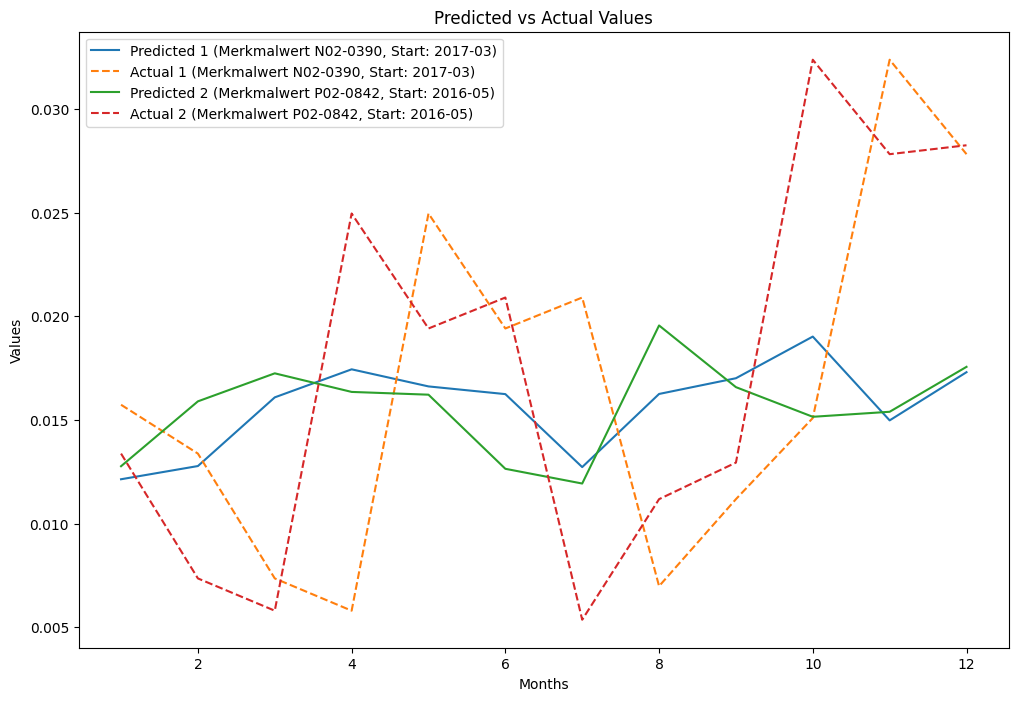

In [80]:
# Vergleich der Vorhersagen mit den tatsächlichen Werten
for i in range(min(len(predictions_rescaled), 5)):  # Zeige die ersten 5 Vorhersagen
    print(f"Prediction {i + 1}:")
    print(predictions_rescaled[i])
    print(f"Actual {i + 1}:")
    print(y_test_rescaled[i])

# Ergebnisse in einer Tabelle anzeigen
results = pd.DataFrame(predictions_rescaled[:5], columns=[f'Predicted_{i+1}' for i in range(12)])
actuals = pd.DataFrame(y_test_rescaled[:5], columns=[f'Actual_{i+1}' for i in range(12)])
results_combined = pd.concat([results, actuals], axis=1)
print(results_combined)

# Grafische Darstellung
plt.figure(figsize=(12, 8))
for i in range(2):  # Zeige die ersten 5 Vorhersagen
    plt.plot(range(1, 13), predictions_rescaled[i], label=f'Predicted {i+1} (Merkmalwert {merkmalwerte_test[i]}, Start: {start_dates_test[i].strftime("%Y-%m")})')
    plt.plot(range(1, 13), y_test_rescaled[i], label=f'Actual {i+1} (Merkmalwert {merkmalwerte_test[i]}, Start: {start_dates_test[i].strftime("%Y-%m")})', linestyle='dashed')
plt.xlabel('Months')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()

In [ ]:
def show_original_sequences(self, X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, idx=0):
        """
        Zeigt eine spezifische Sequenz in ihrer ursprünglichen Skalierung an.

        :param X_cont_seq: Sequenzen der kontinuierlichen Merkmale
        :param X_enc_seq: Sequenzen der kodierten Merkmale
        :param y_seq: Zielsequenzen
        :param start_dates: Startdaten der Sequenzen
        :param merkmalwerte: Merkmalwerte der Sequenzen
        :param idx: Index der anzuzeigenden Sequenz
        """
        if len(X_cont_seq) == 0:
            print("No sequences available to show.")
            return
        
        # Originale kontinuierliche Features
        X_cont_original = np.zeros_like(X_cont_seq[idx])
        for i, feature in enumerate(self.scalers.keys()):
            X_cont_original[:, i] = self.scalers[feature].inverse_transform(X_cont_seq[idx][:, i].reshape(-1, 1)).flatten()
        
        # Originale Zielsequenzen
        y_original = np.zeros_like(y_seq[idx])
        y_scaler = MinMaxScaler()
        y_scaler.fit(y_seq[idx].reshape(-1, 1))
        y_original = y_scaler.inverse_transform(y_seq[idx].reshape(-1, 1)).flatten()

        print(f"Original Continuous Features Sequence for Merkmalwert {merkmalwerte[idx]} starting at {start_dates[idx]}:")
        print(X_cont_original)
        print("Encoded Features Sequence (remains unchanged):")
        print(X_enc_seq[idx])
        print("Original Target Sequence:")
        print(y_original)

In [31]:
df[df["Merkmalwert"] == "N05-0129"].tail(60)

,Datum,Merkmal,Merkmalwert,Bestätigte Menge,Relativer Anteil,USTR10Y,CBIPSFE,WeizenSpot,CornSpot,CBI,GER10Y,WtiOilSpot,SoySpot,CBIPS,AgriSpot,Jahr,Monat,Monat_sin,Monat_cos
8920,2019-10-01,N05,N05-0129,0,0.000000,1.644,-27.9,165.024,171.822,-22.1,-0.557,53.62,186.634,-16.3,166.425,2019,10,-8.660254e-01,5.000000e-01
8921,2019-11-01,N05,N05-0129,0,0.000000,1.728,-16.0,170.113,170.551,-17.6,-0.377,56.00,189.415,-19.1,170.719,2019,11,-5.000000e-01,8.660254e-01
8922,2019-12-01,N05,N05-0129,0,0.000000,1.836,-17.9,174.152,164.301,-18.4,-0.278,55.96,178.244,-18.9,169.682,2019,12,-2.449294e-16,1.000000e+00
8923,2020-01-01,N05,N05-0129,2,0.010989,1.910,-21.2,181.502,169.915,-17.7,-0.187,61.08,191.171,-14.1,176.671,2020,1,5.000000e-01,8.660254e-01
8924,2020-02-01,N05,N05-0129,0,0.000000,1.520,-2.0,178.918,163.877,-2.6,-0.436,50.11,176.488,-3.1,171.862,2020,2,8.660254e-01,5.000000e-01
8925,2020-03-01,N05,N05-0129,3,0.012552,1.088,-13.9,169.063,159.640,-9.4,-0.620,46.75,177.707,-5.0,168.283,2020,3,1.000000e+00,6.123234e-17
8926,2020-04-01,N05,N05-0129,4,0.050633,0.635,-80.8,178.072,144.386,-66.3,-0.470,20.31,169.018,-51.5,156.770,2020,4,8.660254e-01,-5.000000e-01
8927,2020-05-01,N05,N05-0129,9,0.058442,0.640,-69.5,173.667,137.924,-58.6,-0.586,19.78,166.976,-47.6,152.006,2020,5,5.000000e-01,-8.660254e-01
8928,2020-06-01,N05,N05-0129,3,0.018182,0.662,-47.5,175.363,139.647,-47.0,-0.393,35.44,168.341,-46.5,152.876,2020,6,1.224647e-16,-1.000000e+00
8929,2020-07-01,N05,N05-0129,5,0.032051,0.682,-25.0,167.447,157.839,-20.0,-0.400,39.82,175.659,-15.0,156.907,2020,7,-5.000000e-01,-8.660254e-01


In [77]:
df = pd.read_csv('DataFrame.csv')
df["Datum"] = pd.to_datetime(df["Datum"])

# Erstellen von Jahr- und Monatsspalten
df['Jahr'] = df["Datum"].dt.year
df['Monat'] = df["Datum"].dt.month

# Erstellen zyklischer Eigenschaften für den Monat
df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)

# Auswahl der Zielvariable und der Features
df_t = df["Bestätigte Menge"]
df_f = df[['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']]


In [80]:
df_m = df[df["Merkmalwert"] == "N05-0129"]
df_m.head(60)


,Datum,Merkmal,Merkmalwert,Bestätigte Menge,Relativer Anteil,USTR10Y,CBIPSFE,WeizenSpot,CornSpot,CBI,GER10Y,WtiOilSpot,SoySpot,CBIPS,AgriSpot,Jahr,Monat,Monat_sin,Monat_cos
8854,2014-04-01,N05,N05-0129,12,0.060000,2.755,-1.0,222.170,215.466,4.1,1.581,99.74,281.258,9.2,233.772,2014,4,8.660254e-01,-5.000000e-01
8855,2014-05-01,N05,N05-0129,1,0.007812,2.613,-12.7,241.438,212.924,-6.4,1.470,99.42,242.195,0.0,236.510,2014,5,5.000000e-01,-8.660254e-01
8856,2014-06-01,N05,N05-0129,0,0.000000,2.527,-24.3,220.032,194.965,-15.1,1.368,102.47,242.683,-5.8,214.915,2014,6,1.224647e-16,-1.000000e+00
8857,2014-07-01,N05,N05-0129,0,0.000000,2.566,-24.2,204.120,189.725,-17.4,1.249,105.34,229.512,-10.5,201.409,2014,7,-5.000000e-01,-8.660254e-01
8858,2014-08-01,N05,N05-0129,1,0.050000,2.494,-28.4,189.661,168.644,-23.0,1.139,97.88,212.341,-17.5,188.486,2014,8,-8.660254e-01,-5.000000e-01
8859,2014-09-01,N05,N05-0129,0,0.000000,2.345,-29.9,191.357,169.174,-30.4,0.884,95.96,204.927,-30.9,190.507,2014,9,-1.000000e+00,-1.836970e-16
8860,2014-10-01,N05,N05-0129,0,0.000000,2.389,-38.9,161.955,151.589,-37.9,0.906,90.73,185.073,-36.8,173.713,2014,10,-8.660254e-01,5.000000e-01
8861,2014-11-01,N05,N05-0129,0,0.000000,2.346,-50.5,180.048,172.352,-44.0,0.860,78.78,203.512,-37.4,191.032,2014,11,-5.000000e-01,8.660254e-01
8862,2014-12-01,N05,N05-0129,3,0.014423,2.236,-41.0,197.900,173.729,-42.5,0.729,69.00,202.000,-44.0,195.542,2014,12,-2.449294e-16,1.000000e+00
8863,2015-01-01,N05,N05-0129,1,0.004926,2.170,-40.2,192.084,175.953,-38.5,0.541,53.27,202.341,-36.8,190.917,2015,1,5.000000e-01,8.660254e-01


In [82]:
def create_rolling_sequences(df, target_column, feature_columns, n, m):
    """
    Erstellt Sequenzen für die Eingabedaten und Zielsequenzen basierend auf einem Rolling Window.
    
    :param df: Zeitreihe als Pandas DataFrame
    :param target_column: Spaltenname der Zielvariable
    :param feature_columns: List der Spaltennamen der Features
    :param n: Länge der Eingabesequenzen
    :param m: Länge der Zielsequenzen
    :return: Tuple (input_sequences, target_sequences)
    """
    input_sequences = []
    target_sequences = []
    
    data = df[feature_columns + [target_column]].values
    
    for i in range(len(data) - n - m + 1):
        input_seq = data[i:i+n, :-1]
        target_seq = data[i+n:i+n+m, -1]
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        
    return np.array(input_sequences), np.array(target_sequences)

# Beispielnutzung
target_column = "Bestätigte Menge"
feature_columns = ['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']

# Sequenzen erstellen
n = 12  # Länge der Eingabesequenz
m = 12  # Länge der Zielsequenz
input_sequences, target_sequences = create_rolling_sequences(df_m, target_column, feature_columns, n, m)

# Beispielhafte Anzeige der ersten Eingabe- und Zielsequenz
print("Erste Eingabesequenz:")
print(input_sequences[0])
print("Erste Zielsequenz:")
print(target_sequences[0])


Erste Eingabesequenz:
[[ 2.01400000e+03  8.66025404e-01 -5.00000000e-01  2.75500000e+00
   2.22170000e+02  2.15466000e+02  1.58100000e+00  9.97400000e+01
   2.81258000e+02  2.33772000e+02]
 [ 2.01400000e+03  5.00000000e-01 -8.66025404e-01  2.61300000e+00
   2.41438000e+02  2.12924000e+02  1.47000000e+00  9.94200000e+01
   2.42195000e+02  2.36510000e+02]
 [ 2.01400000e+03  1.22464680e-16 -1.00000000e+00  2.52700000e+00
   2.20032000e+02  1.94965000e+02  1.36800000e+00  1.02470000e+02
   2.42683000e+02  2.14915000e+02]
 [ 2.01400000e+03 -5.00000000e-01 -8.66025404e-01  2.56600000e+00
   2.04120000e+02  1.89725000e+02  1.24900000e+00  1.05340000e+02
   2.29512000e+02  2.01409000e+02]
 [ 2.01400000e+03 -8.66025404e-01 -5.00000000e-01  2.49400000e+00
   1.89661000e+02  1.68644000e+02  1.13900000e+00  9.78800000e+01
   2.12341000e+02  1.88486000e+02]
 [ 2.01400000e+03 -1.00000000e+00 -1.83697020e-16  2.34500000e+00
   1.91357000e+02  1.69174000e+02  8.84000000e-01  9.59600000e+01
   2.049270

In [71]:
for merkmalwert, group in df.groupby('Merkmalwert'):
    print(merkmalwert, group)

B10-0030          Datum Merkmal Merkmalwert  Bestätigte Menge  Relativer Anteil  \
0   2014-01-01     B10    B10-0030                 0          0.000000   
1   2014-02-01     B10    B10-0030                 0          0.000000   
2   2014-03-01     B10    B10-0030                 0          0.000000   
3   2014-04-01     B10    B10-0030                48          0.125654   
4   2014-05-01     B10    B10-0030                42          0.156134   
5   2014-06-01     B10    B10-0030                19          0.106145   
6   2014-07-01     B10    B10-0030                 0          0.000000   
7   2014-08-01     B10    B10-0030                 0          0.000000   
8   2014-09-01     B10    B10-0030                 0          0.000000   
9   2014-10-01     B10    B10-0030                 0          0.000000   
10  2014-11-01     B10    B10-0030                 0          0.000000   
11  2014-12-01     B10    B10-0030                17          0.076233   
12  2015-01-01     B10    B10

In [76]:
import pandas as pd
import numpy as np

def create_rolling_sequences(data, n, m):
    """
    Erstellt Sequenzen für die Eingabedaten und Zielsequenzen basierend auf einem Rolling Window.
    
    :param data: Zeitreihe als Pandas DataFrame
    :param n: Länge der Eingabesequenzen
    :param m: Länge der Zielsequenzen
    :return: Tuple (input_sequences, target_sequences)
    """
    input_sequences = []
    target_sequences = []
    
    for i in range(len(data) - n - m + 1):
        input_seq = data[i:i+n].values
        target_seq = data[i+n:i+n+m].values
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        
    return input_sequences, target_sequences

# Beispielnutzung
df = pd.read_csv('CLAAS_data/MLbase_DataFrame.csv')
df["Datum"] = pd.to_datetime(df["Datum"])

# Erstellen von Jahr- und Monatsspalten
df['Jahr'] = df["Datum"].dt.year
df['Monat'] = df["Datum"].dt.month

# Erstellen zyklischer Eigenschaften für den Monat
df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)

# Auswahl der Zielvariable und der Features
df_t = df["Bestätigte Menge"]
df_f = df[['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']]

# Kombinieren der Features und der Zielvariable
combined_df = pd.concat([df_f, df_t], axis=1)

# Sequenzen erstellen
n = 12  # Länge der Eingabesequenz
m = 12  # Länge der Zielsequenz
input_sequences, target_sequences = create_rolling_sequences(combined_df, n, m)

# Beispielhafte Anzeige der ersten Eingabe- und Zielsequenz
print("Erste Eingabesequenz:")
print(input_sequences[0])
print("Erste Zielsequenz:")
print(target_sequences[0])


Erste Eingabesequenz:
[[ 2.01300000e+03  8.66025404e-01 -5.00000000e-01             nan
              nan             nan             nan             nan
              nan             nan  3.00000000e+00]
 [ 2.01300000e+03  5.00000000e-01 -8.66025404e-01             nan
              nan             nan             nan             nan
              nan             nan  0.00000000e+00]
 [ 2.01300000e+03  1.22464680e-16 -1.00000000e+00             nan
              nan             nan             nan             nan
              nan             nan  0.00000000e+00]
 [ 2.01300000e+03 -5.00000000e-01 -8.66025404e-01             nan
              nan             nan             nan             nan
              nan             nan  0.00000000e+00]
 [ 2.01300000e+03 -8.66025404e-01 -5.00000000e-01             nan
              nan             nan             nan             nan
              nan             nan  0.00000000e+00]
 [ 2.01300000e+03 -1.00000000e+00 -1.83697020e-16             n

In [46]:
class TimeSeriesSequencer:
    def __init__(self, file_path, date_column, target_column, sequence_length=12):
        """
        Initialisiert die Klasse TimeSeriesSequencer.

        :param file_path: Pfad zur CSV-Datei mit den Daten
        :param date_column: Spaltenname für das Datum
        :param target_column: Spaltenname für die Zielvariable
        :param sequence_length: Länge der Sequenzen
        """
        self.file_path = file_path
        self.date_column = date_column
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.data = None
        self.label_encoders = {}
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        
    def load_data(self):
        """
        Lädt die Daten aus der CSV-Datei und erstellt zusätzliche Features basierend auf dem Datum.
        """
        # Laden der CSV-Datei
        self.data = pd.read_csv(self.file_path)
        # Konvertieren der Datumsspalte in das Datetime-Format
        self.data[self.date_column] = pd.to_datetime(self.data[self.date_column])
        # Erstellen von Jahr- und Monatsspalten
        self.data['Jahr'] = self.data[self.date_column].dt.year
        self.data['Monat'] = self.data[self.date_column].dt.month
        # Erstellen zyklischer Eigenschaften für den Monat
        self.data['Monat_sin'] = np.sin(2 * np.pi * self.data['Monat'] / 12)
        self.data['Monat_cos'] = np.cos(2 * np.pi * self.data['Monat'] / 12)
        
    def encode_categorical_features(self, categorical_features):
        """
        Kodiert kategoriale Merkmale mittels Label-Encoding.

        :param categorical_features: Liste der kategorialen Merkmale
        """
        for feature in categorical_features:
            # Initialisieren des LabelEncoders
            le = LabelEncoder()
            # Anpassen und Transformieren der Daten
            self.data[f'{feature}_encoded'] = le.fit_transform(self.data[feature])
            # Speichern des LabelEncoders
            self.label_encoders[feature] = le

    def normalize_features(self, continuous_features):
        """
        Normalisiert kontinuierliche Merkmale.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        """
        # Normalisieren der kontinuierlichen Merkmale außer "Jahr"
        other_cont_features = [feat for feat in continuous_features if feat != 'Jahr']
        self.data[other_cont_features] = self.scaler_X.fit_transform(self.data[other_cont_features])
        # Normalisieren der "Jahr"-Spalte separat
        self.data[['Jahr']] = MinMaxScaler().fit_transform(self.data[['Jahr']])
        
    def create_sequences(self, continuous_features, encoded_features):
        """
        Erstellt Sequenzen für das Training des Modells.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        :param encoded_features: Liste der kodierten Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = [], [], [], [], []
        
        # Gruppieren der Daten nach "Merkmalwert"
        for merkmalwert, group in self.data.groupby('Merkmalwert'):
            # Sortieren der Gruppen nach Datum
            group = group.sort_values(by=self.date_column)
            # Auswählen der kontinuierlichen und kodierten Merkmale
            X_continuous = group[continuous_features]
            X_encoded = group[encoded_features]
            
            # Erstellen der Zielsequenzen für die nächsten 12 Monate
            y = pd.concat([group[self.target_column].shift(-i) for i in range(1, 13)], axis=1).dropna()
            #print(y)
            y.columns = [f'R_A_{i+1}' for i in range(12)]

            # Überprüfen der Anzahl der Zielspalten
            print(f"Group {merkmalwert} - Zielsequenzen: {y.shape}")
            
            # Überprüfen, ob genügend Daten vorhanden sind
            if len(y) < self.sequence_length + 12 - 1:
                continue
            
            # Anpassen der Features an die Zielsequenzen
            X_continuous = X_continuous.iloc[:len(y)]
            X_encoded = X_encoded.iloc[:len(y)]
            
            # Normalisieren der Zielvariablen
            y_scaled = self.scaler_y.fit_transform(y)
            
            for i in range(len(X_continuous) - self.sequence_length):
                date_seq = group[self.date_column].iloc[i:i+self.sequence_length]
                expected_dates = pd.date_range(start=date_seq.iloc[0], periods=self.sequence_length, freq='MS')
                # Überprüfen, ob die Daten eine kontinuierliche Sequenz bilden
                if date_seq.reset_index(drop=True).equals(expected_dates.to_series().reset_index(drop=True)):
                    X_cont_seq.append(X_continuous.iloc[i:i+self.sequence_length].values)
                    X_enc_seq.append(X_encoded.iloc[i:i+self.sequence_length].values)
                    y_seq.append(y_scaled[i:i+12])
                    start_dates.append(date_seq.iloc[0])
                    merkmalwerte.append(merkmalwert)
                else:
                    print(f"Skipping non-continuous sequence starting at {date_seq.iloc[0]} for Merkmalwert {merkmalwert}")
                    print(f"Expected dates: {expected_dates}")
                    print(f"Actual dates: {date_seq}")
                       
        print(f"Total sequences created: {len(X_cont_seq)}")
        return np.array(X_cont_seq), np.array(X_enc_seq), np.array(y_seq), start_dates, merkmalwerte

    def get_data(self, categorical_features, continuous_features):
        """
        Lädt die Daten, kodiert kategoriale Merkmale, normalisiert kontinuierliche Merkmale und erstellt Sequenzen.

        :param categorical_features: Liste der kategorialen Merkmale
        :param continuous_features: Liste der kontinuierlichen Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        self.load_data()
        self.encode_categorical_features(categorical_features)
        self.normalize_features(continuous_features)
        encoded_features = [f'{feature}_encoded' for feature in categorical_features]
        return self.create_sequences(continuous_features, encoded_features)

    def show_sequences(self, X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, idx=0):
        """
        Zeigt eine spezifische Sequenz an.

        :param X_cont_seq: Sequenzen der kontinuierlichen Merkmale
        :param X_enc_seq: Sequenzen der kodierten Merkmale
        :param y_seq: Zielsequenzen
        :param start_dates: Startdaten der Sequenzen
        :param merkmalwerte: Merkmalwerte der Sequenzen
        :param idx: Index der anzuzeigenden Sequenz
        """
        if len(X_cont_seq) == 0:
            print("No sequences available to show.")
            return
        print(f"Continuous Features Sequence for Merkmalwert {merkmalwerte[idx]} starting at {start_dates[idx]}:")
        print(X_cont_seq[idx])
        print("Encoded Features Sequence:")
        print(X_enc_seq[idx])
        print("Target Sequence:")
        print(y_seq[idx])


In [53]:
# Beispielnutzung
file_path = 'CLAAS_data/MLbase_DataFrame.csv'
date_column = 'Datum'
target_column = 'Bestätigte Menge'
categorical_features = ['Merkmal', 'Merkmalwert']
continuous_features = ['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']

sequencer = TimeSeriesSequencer(file_path, date_column, target_column)
X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = sequencer.get_data(categorical_features, continuous_features)

# Daten in Trainings- und Testsets aufteilen
X_cont_train, X_cont_test, X_enc_train, X_enc_test, y_train, y_test, start_dates_train, start_dates_test, merkmalwerte_train, merkmalwerte_test = train_test_split(
    X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, test_size=0.2, random_state=42, shuffle=True
)

print(f"Total training sequences: {len(X_cont_train)}")
print(f"Total test sequences: {len(X_cont_test)}")

# Anzeigen einer Beispielsequenz (z.B. die erste Sequenz)
#sequencer.show_sequences(X_cont_train, X_enc_train, y_train, start_dates_train, merkmalwerte_train, idx=0)


Group B10-0030 - Zielsequenzen: (34, 12)
Group B10-0033 - Zielsequenzen: (22, 12)
Group B10-0035 - Zielsequenzen: (92, 12)
Group B10-0036 - Zielsequenzen: (69, 12)
Group B10-0038 - Zielsequenzen: (54, 12)
Group B10-0039 - Zielsequenzen: (25, 12)
Group B10-0040 - Zielsequenzen: (76, 12)
Group B10-0042 - Zielsequenzen: (53, 12)
Group B10-0046 - Zielsequenzen: (0, 12)
Group B10-0090 - Zielsequenzen: (75, 12)
Group B10-0091 - Zielsequenzen: (52, 12)
Group B10-0092 - Zielsequenzen: (39, 12)
Group B10-0100 - Zielsequenzen: (34, 12)
Group B10-0102 - Zielsequenzen: (63, 12)
Group B10-0104 - Zielsequenzen: (35, 12)
Group B10-0105 - Zielsequenzen: (14, 12)
Group B10-0110 - Zielsequenzen: (33, 12)
Group B10-0120 - Zielsequenzen: (57, 12)
Group B10-0130 - Zielsequenzen: (41, 12)
Group B10-0140 - Zielsequenzen: (57, 12)
Group B10-0150 - Zielsequenzen: (49, 12)
Group B10-0160 - Zielsequenzen: (58, 12)
Group B10-0161 - Zielsequenzen: (7, 12)
Group B10-0170 - Zielsequenzen: (62, 12)
Group B10-0175 - Z

In [25]:
# Beispielnutzung
file_path = 'CLAAS_data/MLbase_DataFrame.csv'
date_column = 'Datum'
target_column = 'Bestätigte Menge'
categorical_features = ['Merkmal', 'Merkmalwert']
continuous_features = ['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']

sequencer = TimeSeriesSequencer(file_path, date_column, target_column)
X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = sequencer.get_data(categorical_features, continuous_features)

# Daten in Trainings- und Testsets aufteilen
X_cont_train, X_cont_test, X_exnc_train, X_enc_test, y_train, y_test, start_dates_train, start_dates_test, merkmalwerte_train, merkmalwerte_test = train_test_split(
    X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, test_size=0.2, random_state=42, shuffle=True
)

print(f"Total training sequences: {len(X_cont_train)}")
print(f"Total test sequences: {len(X_cont_test)}")

# Anzeigen einer Beispielsequenz (z.B. die erste Sequenz)
sequencer.show_original_sequences(X_cont_train, X_enc_train, y_train, start_dates_train, merkmalwerte_train, idx=0)

Group B10-0030 - Zielsequenzen: (34, 12)
Group B10-0033 - Zielsequenzen: (22, 12)
Group B10-0035 - Zielsequenzen: (92, 12)
Group B10-0036 - Zielsequenzen: (69, 12)
Group B10-0038 - Zielsequenzen: (54, 12)
Group B10-0039 - Zielsequenzen: (25, 12)
Group B10-0040 - Zielsequenzen: (76, 12)
Group B10-0042 - Zielsequenzen: (53, 12)
Group B10-0046 - Zielsequenzen: (0, 12)
Group B10-0090 - Zielsequenzen: (75, 12)
Group B10-0091 - Zielsequenzen: (52, 12)
Group B10-0092 - Zielsequenzen: (39, 12)
Group B10-0100 - Zielsequenzen: (34, 12)
Group B10-0102 - Zielsequenzen: (63, 12)
Group B10-0104 - Zielsequenzen: (35, 12)
Group B10-0105 - Zielsequenzen: (14, 12)
Group B10-0110 - Zielsequenzen: (33, 12)
Group B10-0120 - Zielsequenzen: (57, 12)
Group B10-0130 - Zielsequenzen: (41, 12)
Group B10-0140 - Zielsequenzen: (57, 12)
Group B10-0150 - Zielsequenzen: (49, 12)
Group B10-0160 - Zielsequenzen: (58, 12)
Group B10-0161 - Zielsequenzen: (7, 12)
Group B10-0170 - Zielsequenzen: (62, 12)
Group B10-0175 - Z

ValueError: operands could not be broadcast together with shapes (12,12) (9,) (12,12) 

In [10]:
X_cont_seq.shape

(4103, 12, 10)

In [ ]:
for i in range(len(X_continuous) - self.sequence_length - 12 + 1):
    date_seq = group[self.date_column].iloc[i:i+self.sequence_length]
    expected_dates = pd.date_range(start=date_seq.iloc[0], periods=self.sequence_length, freq='MS')
    if date_seq.reset_index(drop=True).equals(expected_dates.to_series().reset_index(drop=True)):
        X_cont_seq.append(X_continuous.iloc[i:i+self.sequence_length].values)
        X_enc_seq.append(X_encoded.iloc[i:i+self.sequence_length].values)
        y_seq.append(y_scaled[i+self.sequence_length:i+self.sequence_length+12])
        start_dates.append(date_seq.iloc[0])
        merkmalwerte.append(merkmalwert)


# Experimente